# Problem Set 3 (24 points)

Use the same `sentencing_cleaned` data from Problem Set 2 for this assignment. 

In Problem Set 2, you investigated one form of disparity in the US criminal justice system: probation versus incarceration.

Here, you'll investigate a second type of disparity---the length of a defendant's sentence---and also investigate the disparities faced by defendants sentenced by the same judge for the same crime. 

As a reminder, the codebook is available at this link:  https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf)

# 0. Load packages and imports

In [2]:
## basic functionality
import pandas as pd
import numpy as np
import re
import os
# import plotnine
# from plotnine import *

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 1.1 Filter to defendants who were incarcerated and construct a sentence length variable (10 points)

**Part A:**

- Filter to sentences that involve incarceration (same Illinois Department of Corrections logic as in problem set two: 
incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections")
- Filter out non-numeric sentence lengths (e.g., Term, Pounds, or Dollars)
- Filter to Black or White defendants

**Concepts tested and resources**: this question tests filtering rows based on logical conditions. Here are some resources:
- DataCamp on .loc: https://campus.datacamp.com/courses/data-manipulation-with-pandas/slicing-and-indexing-dataframes?ex=3
- Row subsetting section in this activity: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb


### Part A

In [4]:
## your code here that reads in data and filters the rows
df = pd.read_csv("pset2_inputdata/sentencing_cleaned.csv")
df.shape
numeric_term_units = ["Year(s)", "Natural Life", "Hours", "Months", "Days", "Weeks"]

df = df[(df["COMMITMENT_TYPE"] == "Illinois Department of Corrections") \
        & (~pd.to_numeric(df["COMMITMENT_TERM"], errors='coerce').isna()) \
        & (df["COMMITMENT_UNIT"].isin(numeric_term_units)) \
        & (df.is_white_derived | df.is_black_derived)]

<ipython-input-4-92eb251999dc>:2: DtypeWarning: Columns (10,11,16,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("pset2_inputdata/sentencing_cleaned.csv")


(135165, 52)

### Part B


**Part B**: Then, follow the instructions in the codebook (combining `COMMITMENT_TERM` with `COMMITMENT_UNIT`) to create a standard sentence length in days column (`senlength_derived`) that measures the sentence in days. To simplify, you can assume that:

- 1 hour = 1/24th of a day
- 1 year = 365 days
- 1 month = 30.5 days
- 1 week = 7 days
- Natural life = difference between the age of 100 and the defendant's age at incident (cleaned; if missing, code to age 20); note that this is a simplification since age at incident != age at sentencing 

Print the following cols for an example of each type (eg an example of originally hours; an example of natural life): `COMMITMENT_TERM`, `COMMITMENT_UNIT`, `age_derived` and your new standardized sentence length column

Print the summary of that column (`senlength_derived`) using the .describe() command

**Concepts tested and resources**: there are many approaches but a couple ways are:
- np.select covered in the slides and this activity notebook: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb
- writing a function that takes in one row as an argument and has a series of if, elif, else conditions where different commitment_units are translated into days. To execute this function, you can use the .apply function but apply it with axis = 1 (row-wise). Resources for that include: (1) the activity notebook on user-defined functions (https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/02_functions_part1_solutions.ipynb); (2) the activity notebook covering apply (same as above)

**Hint on output**: see GitHub issue for the summary stats we get from running .describe()

In [5]:
## Your code here on translation of units
#df["senlength_derived"] = []

def translate_units(df):
    unit_map = {
        "Day": 1,
        "Hour": 1/24,
        "Year": 365,
        "Month": 30.5,
        "Week": 7
    }

    for t in unit_map:
        if t in df["COMMITMENT_UNIT"]:
            df["senlength_derived"] = unit_map[t] * float(df["COMMITMENT_TERM"])
        elif "Natural" in df["COMMITMENT_UNIT"]:
            df["senlength_derived"] = (100 - float(df["AGE_AT_INCIDENT"])) * 365

    return df

df["AGE_AT_INCIDENT"] = df["AGE_AT_INCIDENT"].fillna(20)
df = df.apply(translate_units, axis=1)

display(df)

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_black_derived,is_hisp_derived,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived,senlength_derived
0,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,True,False,False,False,True,27.0,2014-10-16,2014-10-01,judge_40,22630.0
1,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,True,False,False,False,True,30.0,2014-08-06,2014-08-01,judge_310,25550.0
5,155685924389,221749325828,6/15/2001 12:00:00 AM,PROMIS Conversion,True,55017536987,687589180737,AGGRAVATED CRIMINAL SEXUAL ASSAULT,1,5/3/2013 12:00:00 AM,...,True,False,False,False,True,NaN,2013-05-03,2013-05-01,judge_287,3650.0
7,156558681704,231553844285,7/17/2001 12:00:00 AM,PROMIS Conversion,True,58235136444,720561595284,2ND DEGREE MURDER,1,12/4/2014 12:00:00 AM,...,True,False,False,False,True,17.0,2014-12-04,2014-12-01,judge_329,7300.0
9,156996749190,238415836990,10/20/2001 12:00:00 AM,PROMIS Conversion,True,58424726399,219609793234,MURDER/INTENT TO KILL/INJURE,1,3/14/2012 12:00:00 AM,...,True,False,False,False,True,23.0,2012-03-14,2012-03-01,judge_113,16425.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135117,444576672584,902195288394,11/19/2020 12:00:00 AM,Driving With Suspended Or Revoked License,True,446042822953,832902252993,"FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT,...",1,3/16/2021 12:00:00 AM,...,True,False,False,False,True,45.0,2021-02-19,2021-02-01,judge_287,549.0
135128,444757010121,902797855005,12/4/2020 12:00:00 AM,Credit Card Cases,True,446970360764,834641370221,IDENTITY THEFT,1,3/2/2021 12:00:00 AM,...,False,False,True,False,True,44.0,2021-02-17,2021-02-01,judge_90,1825.0
135143,444982872606,903587656097,9/19/2014 12:00:00 AM,Forgery,True,446915459615,834537766815,FORGERY,1,3/19/2021 12:00:00 AM,...,True,False,False,False,True,33.0,2021-03-03,2021-03-01,judge_287,730.0
135151,445140741379,904087923223,1/7/2021 12:00:00 AM,Possession of Stolen Motor Vehicle,True,447180111306,837593366637,ATTEMPT POSSESSION OF A STOLEN MOTOR VEHICLE,1,3/2/2021 12:00:00 AM,...,True,False,False,False,True,24.0,2021-03-02,2021-03-01,judge_4,730.0


In [6]:
## Your code here on printing example of each type of committment unit and what it's senlength_derived is
df.groupby("COMMITMENT_UNIT").head(1)[["COMMITMENT_TERM", "COMMITMENT_UNIT", "age_derived", "senlength_derived"]]

,COMMITMENT_TERM,COMMITMENT_UNIT,age_derived,senlength_derived
0,62.0,Year(s),27.0,22630.000000
1,1.0,Natural Life,30.0,25550.000000
194,18.0,Months,29.0,549.000000
4697,90.0,Days,40.0,90.000000
15310,2.0,Weeks,23.0,14.000000
92475,1.0,Hours,22.0,0.041667


In [7]:
## Your code here with the .describe() command summary of the senlength_derived column
df["senlength_derived"].describe()

count     58289.000000
mean       1396.720826
std        2062.874778
min           0.000000
25%         366.000000
50%         915.000000
75%        1460.000000
max      147825.000000
Name: senlength_derived, dtype: float64

## 1.2 Examine disparities in length within the same judge and offense category: constructing matched pairs (14 points)



### Part A 

Keep the above ~58k row dataset subsetting only to sentences involving incarceration. Then, further subset the rows to:
- Those sentenced `judgeid_derived` = `judge_21` 
- `simplified_offense_derived` == "Narcotics"

Use `shape` to print the dimensions of the resulting dataframe

**Concepts and resources**: row subsetting using logical conditions; see above resources
 

In [8]:
## your code here to filter rows and check the shape
judge_df = df[(df.judgeid_derived == "judge_21") & (df.simplified_offense_derived == "Narcotics")]
judge_df.shape

(53, 53)

### Part B

For each defendant sentenced by judge_21, you want to construct "matched groups" of defendants who:

- Are the same exact age and
- Are the same gender but 
- Differ in race from the focal defendant

Write a user-defined function to find any/all matched defendants for each focal defendant of judge 21. You can structure the function in various ways but one way is to write a function similar to the class example where we find similar crimes to a focal crime for one focal crime; in this case, we want to:

- Iterate over unique defendants sentenced by judge 21 (use `CASE_PARTICIPANT_ID` to identify each unique defendant)
- Find other defendants in the judge 21 pool who (1) have a different race from that focal defendant but (2) the same gender and age 


**Concepts and resources**: 

- Slides and activity code on user-defined functions and iterating using list comprehension: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/02_functions_part1_solutions.ipynb 
- You can either write code in the function to add columns with the attributes of the focal defendant (existing material) or using `pd.merge` to join these on after; we'll be covering `pd.merge` on Wednesday 09.21 but here are some slides (slide 17-20) from my previous course in meantime: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/slides/s21_slides/qss20_s21_class4.pdf 


**Hints on output**: 

- Some focal defendants may not have any matches; they can be excluded from the results 
- In the way we wrote our function, each iteration of the function returns a single dataframe with the focal defendant's matched defendants


In [9]:
## your code here to define function
def grouped_defendants(df, participant_id):
    age = df[df["CASE_PARTICIPANT_ID"] == participant_id].head(1)["AGE_AT_INCIDENT"].iloc[0]
    gender = df[df["CASE_PARTICIPANT_ID"] == participant_id].head(1)["GENDER"].iloc[0]
    race = df[df["CASE_PARTICIPANT_ID"] == participant_id].head(1)["RACE"].iloc[0]
    return df[(df["AGE_AT_INCIDENT"] == age) & (df["GENDER"] == gender) & (df["RACE"] != race)]

In [10]:
## your code here to execute the function
for participant in judge_df["CASE_PARTICIPANT_ID"].unique():
    grouped_defendants(judge_df, participant)[["CASE_PARTICIPANT_ID", "AGE_AT_INCIDENT", "GENDER", "RACE"]]

,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
58381,780425400115,21.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
57019,778820978039,33.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
61939,784727452038,32.0,Male,Black
61940,784728112643,32.0,Male,Black
61941,784728961993,32.0,Male,Black
61942,784730000088,32.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
61939,784727452038,32.0,Male,Black
61940,784728112643,32.0,Male,Black
61941,784728961993,32.0,Male,Black
61942,784730000088,32.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
61939,784727452038,32.0,Male,Black
61940,784728112643,32.0,Male,Black
61941,784728961993,32.0,Male,Black
61942,784730000088,32.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
79738,805461688906,29.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
58381,780425400115,21.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
81801,807995866072,24.0,Male,Black
81892,808109112733,24.0,Male,Black
104703,836672846283,24.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
74782,799701491845,25.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
74782,799701491845,25.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
81801,807995866072,24.0,Male,Black
81892,808109112733,24.0,Male,Black
104703,836672846283,24.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
66907,790505674193,28.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
63152,786169553899,23.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
81801,807995866072,24.0,Male,Black
81892,808109112733,24.0,Male,Black
104703,836672846283,24.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
21175,738433538059,33.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
412,203605700713,21.0,Male,White
44766,764337390649,21.0,Male,White
61379,784075811874,21.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
58381,780425400115,21.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
32289,750050286216,32.0,Male,White
32301,750058968460,32.0,Male,White
32302,750060006554,32.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
32289,750050286216,32.0,Male,White
32301,750058968460,32.0,Male,White
32302,750060006554,32.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
32289,750050286216,32.0,Male,White
32301,750058968460,32.0,Male,White
32302,750060006554,32.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
32289,750050286216,32.0,Male,White
32301,750058968460,32.0,Male,White
32302,750060006554,32.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
51346,772267771231,23.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
49532,770082299410,28.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
79738,805461688906,29.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
48366,768753821700,25.0,Male,Black
48546,768987015450,25.0,Male,Black


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
41448,760456238817,29.0,Male,White
67872,791567550388,29.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
47992,768307912970,24.0,Male,White
49418,769939231128,24.0,Male,White
53700,774967571640,24.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
47992,768307912970,24.0,Male,White
49418,769939231128,24.0,Male,White
53700,774967571640,24.0,Male,White


,CASE_PARTICIPANT_ID,AGE_AT_INCIDENT,GENDER,RACE
47992,768307912970,24.0,Male,White
49418,769939231128,24.0,Male,White
53700,774967571640,24.0,Male,White


**Part B**: using the results from Part A, use `pd.concat` or another approach to create a dataframe that compares the (1) race and sentence length for the focal defendant to (2) the sentence length for other defendants. Using this dataframe, show this comparison for focal defendant: `CASE_PARTICIPANT_ID` == `808109112733`


In [11]:
## your code to rowbind all matches and to highlight the comparison
## for the example defendant 

matches = pd.concat([grouped_defendants(judge_df, participant)[["CASE_PARTICIPANT_ID", "RACE", "senlength_derived"]]\
       .assign(focal=participant, 
               focal_senlength_derived=judge_df[judge_df["CASE_PARTICIPANT_ID"] == participant]["senlength_derived"]\
               .iloc[0], focal_race=judge_df[judge_df["CASE_PARTICIPANT_ID"] == participant]["RACE"].iloc[0]) for participant in judge_df["CASE_PARTICIPANT_ID"].unique()])

matches[matches.focal == 808109112733]

,CASE_PARTICIPANT_ID,RACE,senlength_derived,focal,focal_senlength_derived,focal_race
47992,768307912970,White,730.0,808109112733,2190.0,Black
49418,769939231128,White,730.0,808109112733,2190.0,Black
53700,774967571640,White,365.0,808109112733,2190.0,Black


**Part C**: group by the focal defendant's race and find the proportion of that defendant's matches who had a LONGER sentence than the focal defendant

**Concepts and resources**: can use groupby and agg

- Groupby and agg code: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb

In [12]:
## your code here 
perc_df = matches.groupby(["focal_race"])\
.apply(lambda x: len(x[x["senlength_derived"] > x["focal_senlength_derived"]]) / len(x)).reset_index()

perc_df.rename(columns={0: "percentage_of_matches_longer_sentence"})

,focal_race,percentage_of_matches_longer_sentence
0,Black,0.483871
1,White,0.451613


**Part D**: write 1-2 lines commenting on the results from Part C. What other defendant or offense-level characteristics would you like to match on to investigate claims about racial disparities? 


Another offense-level characteristic I would like to match on would be INCIDENT_CITY. This would ensure that cases in question are even closer to each other, allowing the better isolation of racial disparities.

# 2. Optional extra credit/challenge exercise (1 point): impute possible judge demographic correlates of sentencing

The previous exercises showed large differences in sentences between judges/differences in disparities. You become interested in how the judge's own demographic attributes are correlated with sentencing. Going back to the judge's name (`SENTENCE JUDGE`), parse their first name and try to probabilistically infer his or her gender. Then, investigate whether disparities differ between "likely female" and "likely male" judges. 

**Note on ethics of probabilistic inference of attributes based on name**: Using names to infer demographic characteristics has become increasingly popular with the rise of "digital trace data" that often lacks explicit demographic fields (e.g., tweets just have usernames and profiles; academic citation networks just have author names; voter registration records sometimes just have names and not race/ethnicity). But there are many valid ethical critiques of this practice. In the case of gender, a person's assigned name at birth clearly does not always map onto their self-identified gender, both due to gender fluidity and names like "Morgan." A couple critiques I link to are:

- [This blog post](https://scatter.wordpress.com/2021/07/30/who-writes-social-science/)
- [Urban Institute ethical risks of race/ethnicity imputation - applies to gender](https://www.urban.org/research/publication/five-ethical-risks-consider-filling-missing-race-and-ethnicity-data)

 

In [13]:
# insert code here
import gender_guesser.detector as gender

tmp = df["SENTENCE_JUDGE"].agg({"SENTENCE_JUDGE": lambda x: x[0:x.index(' ')]})
d = gender.Detector()
df["judge_gender"] = [d.get_gender(x) for x in tmp["SENTENCE_JUDGE"]]
df["judge_gender"] = ["likely_male" if x in ["male", "mostly_male"] 
                       else ("likely_female" 
                             if x in ["female", "mostly_female"]
                            else "unknown") for x in df["judge_gender"]]

judge_gender_disparity = df.groupby("judge_gender")["senlength_derived"].median()
display(judge_gender_disparity)

judge_gender
likely_female     730.0
likely_male      1095.0
unknown           915.0
Name: senlength_derived, dtype: float64

Likely female judges tend to sentence defendants to shorter sentences than likely male judges.

# 3. Optional extra credit/challenge exercise (1 point): examine disparities across multiple judges

In problem 1.2, we focused on one judge: judge 21
    
For this extra credit exercise:
    
- Get judges with a sufficient sample size: filter to each judge with at least 20 Black and at least 20 white defendants
- Calculate the within-judge disparity and plot the (1) median sentence length for Black defendants and (2) median sentence length for white defendants (factor variable on x axis for each judge_id who qualifies; group by race)
- Write a 1-2 sentence interpretation - if we assume that cases/defendants are randomly assigned to sentencing judges, what might this suggest about the role of judicial discretion in these disparities?


In [15]:
# insert code here
tmp = df.groupby('judgeid_derived')\
.filter(lambda x: len(x.is_black_derived) >= 20 & len(x.is_white_derived) >= 20)["judgeid_derived"]

disparity_df = df[df.judgeid_derived.isin(tmp)].groupby("judgeid_derived")\
.apply(lambda x: pd.Series([x[x.is_black_derived].senlength_derived.median() - x[x.is_white_derived].senlength_derived.median(), 
                            x[x.is_black_derived].senlength_derived.median(), 
                            x[x.is_white_derived].senlength_derived.median()]))\
.reset_index()

disparity_df = disparity_df.rename(columns={0: "disparity", 1: "black_senlength_median", 2: "white_senlength_median"})

<BarContainer object of 41 artists>

<BarContainer object of 41 artists>

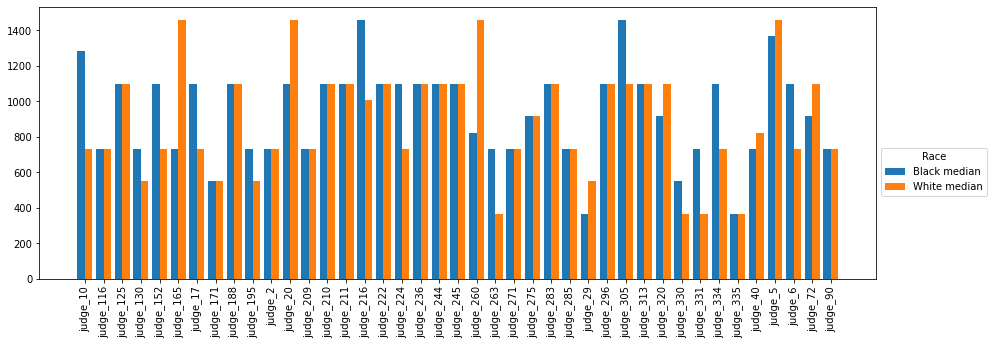

In [16]:
import matplotlib.pyplot as plt

x = np.arange(len(disparity_df["judgeid_derived"]))
plt.bar(x-.2, disparity_df["black_senlength_median"], 0.4, label="Black median")
plt.bar(x+.2,disparity_df["white_senlength_median"], 0.4, label="White median")

plt.legend(title="Race", bbox_to_anchor=(1, 0.5))
_tmp = plt.xticks(x, disparity_df["judgeid_derived"], rotation=90)

plt.gcf().set_size_inches(15, 5)

plt.show()

In [17]:
len(disparity_df[disparity_df["disparity"] > 0])
len(disparity_df[disparity_df["disparity"] < 0])

14

8

In [18]:
df[df["judgeid_derived"] == "judge_165"].groupby("RACE")["senlength_derived"].median()

RACE
Black                                730.0
White                               1460.0
White/Black [Hispanic or Latino]     365.0
Name: senlength_derived, dtype: float64

If cases are randomly assigned to sentencing judges, judicial may impact the extent of dispariies.